# 划分训练集 only use month 1\2\3 in this procedure (train:test 0.8:0.2)

In [49]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

df_model = pd.read_csv("preprocess.csv")
# 只保留 1、2、3 月的数据
# 你已经读好的大表

df = df_model  # 换成你的变量名
df_train = df[df['month'] <= 3]

feature_cols = [
    "Tset_outside",
    "Tset_middle",
    "Dry Bulb Temperature",
    "Dry Bulb Temperature_lag1",
    "Dry Bulb Temperature_lag2",
    "Relative Humidity",
    "Relative Humidity_lag1",
    "Relative Humidity_lag2",
    "Diffuse Horizontal Radiation",
    "Diffuse Horizontal Radiation_lag1",
    "Diffuse Horizontal Radiation_lag2"
]

X = df_train[feature_cols].values
y = df_train["E_HVAC"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# surrogate model： 先用线性回归，构建baseline

Linear Regression R2: 0.7881569870724374
Linear Regression MAE: 7.111369908353692


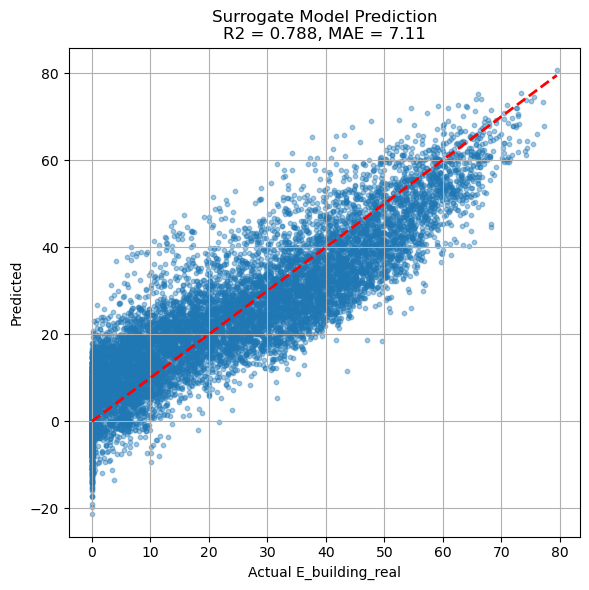

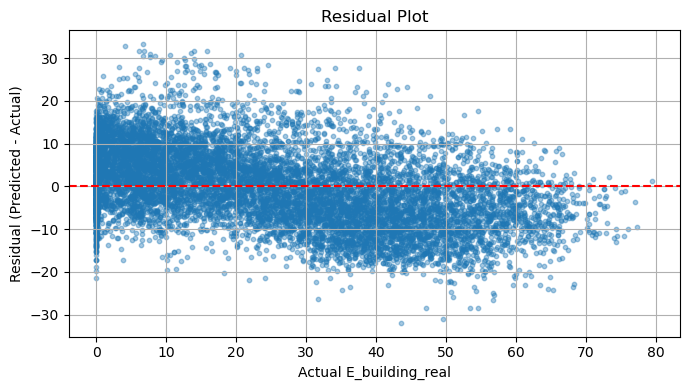

In [50]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred_lr = lr.predict(X_test)
print("Linear Regression R2:", r2_score(y_test, y_pred_lr))
print("Linear Regression MAE:", mean_absolute_error(y_test, y_pred_lr))

import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error

# 1. Predicted vs Actual
y_test_pred = y_pred_lr  # 换成你自己的模型预测，例如 y_pred_gbr、y_pred_mlp

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred, alpha=0.4, s=10)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', linewidth=2)

plt.xlabel("Actual E_building_real")
plt.ylabel("Predicted")
plt.title(f"Surrogate Model Prediction\nR2 = {r2_score(y_test, y_test_pred):.3f}, MAE = {mean_absolute_error(y_test, y_test_pred):.2f}")

plt.grid(True)
plt.tight_layout()
plt.show()


# 2.残差图
residuals = y_test_pred - y_test

plt.figure(figsize=(7,4))
plt.scatter(y_test, residuals, alpha=0.4, s=10)
plt.axhline(0, color='red', linestyle='--')

plt.xlabel("Actual E_building_real")
plt.ylabel("Residual (Predicted - Actual)")
plt.title("Residual Plot")
plt.grid(True)
plt.tight_layout()
plt.show()




# Gradient Boosting 训练

In [51]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# 测试的参数组合
param_grid = {
    "n_estimators": [400, 600],
    "learning_rate": [0.05, 0.1],
    "max_depth": [ 4 ,6],
}

gbr = GradientBoostingRegressor(random_state=45)

grid = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    scoring="r2",        # 也可以换成 'neg_mean_absolute_error'
    cv=4,                # 四折交叉验证
    n_jobs=-1,           # 全核心跑
    verbose=1
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV R2:", grid.best_score_)

# 最优模型预测
best_gbr = grid.best_estimator_

y_pred_gbr = best_gbr.predict(X_test)

print("Test R2:", r2_score(y_test, y_pred_gbr))
print("Test MAE:", mean_absolute_error(y_test, y_pred_gbr))


Fitting 4 folds for each of 8 candidates, totalling 32 fits
Best params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 600}
Best CV R2: 0.9757211750709047
Test R2: 0.9771647537348395
Test MAE: 1.9014293167975762


# XGBoost 训练

In [37]:
from xgboost import XGBRegressor

base_xgb = XGBRegressor(
    tree_method="hist",   
    device="cuda",         
    objective="reg:squarederror",
    random_state=45
)

param_grid = {
    "max_depth": [ 4, 5, 6],          # 树的深度
    "learning_rate": [0.02, 0.05, 0.1],    # 步长
    "n_estimators": [200, 400, 600], # 树的数量
    "subsample": [0.8],         # 行采样，<1.0 有助于防过拟合
    "colsample_bytree": [0.8],  # 列采样
    "reg_lambda": [1.0],   # L2 正则
}

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error

grid = GridSearchCV(
    estimator=base_xgb,
    param_grid=param_grid,
    scoring="r2",      # 也可以用 'neg_mean_absolute_error'
    cv=3,              # 3 折交叉验证就够用了
    n_jobs=-1,         # 用满 CPU
    verbose=1
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV R2:", grid.best_score_)

best_xgb = grid.best_estimator_

y_pred_train = best_xgb.predict(X_train)
y_pred_test  = best_xgb.predict(X_test)

print("Train R2:", r2_score(y_train, y_pred_train))
print("Train MAE:", mean_absolute_error(y_train, y_pred_train))
print("Test R2:", r2_score(y_test, y_pred_test))
print("Test MAE:", mean_absolute_error(y_test, y_pred_test))


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 600, 'reg_lambda': 1.0, 'subsample': 0.8}
Best CV R2: 0.9749376011744234
Train R2: 0.980313127492651
Train MAE: 1.7505678371918039
Test R2: 0.9766412563419515
Test MAE: 1.9436401195179978


# 结果可视化

In [52]:
# importance feature
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importance_generic(model, feature_names, title="Feature Importance"):
    """
    适用于：
    - sklearn.ensemble.GradientBoostingRegressor
    - xgboost.XGBRegressor（使用 feature_importances_ 接口）
    """
    if not hasattr(model, "feature_importances_"):
        raise AttributeError("这个模型没有 feature_importances_ 属性")

    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]  # 从大到小排序

    sorted_importances = importances[indices]
    sorted_names = [feature_names[i] for i in indices]

    plt.figure(figsize=(8, 5))
    plt.barh(range(len(sorted_importances)), sorted_importances[::-1])
    plt.yticks(range(len(sorted_importances)), sorted_names[::-1])
    plt.xlabel("Importance")
    plt.title(title)
    plt.tight_layout()
    plt.show()


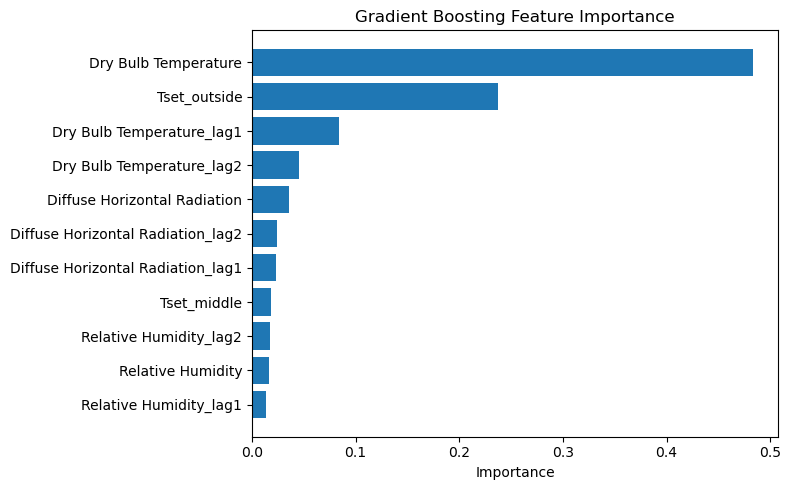

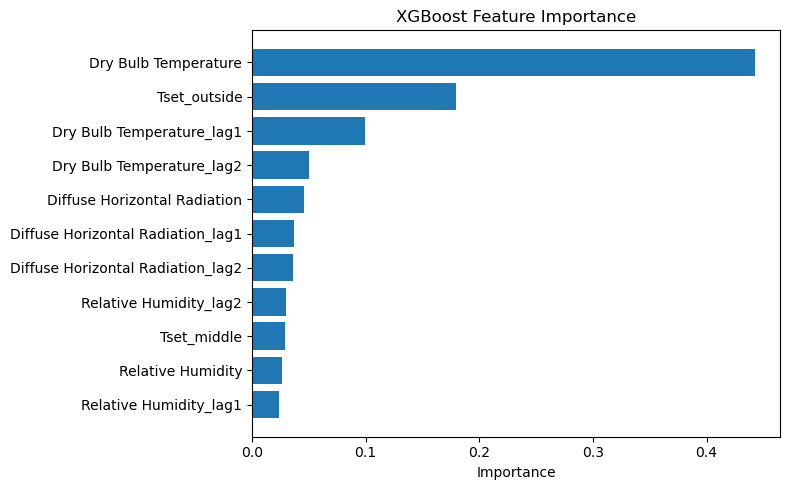

In [53]:
# 对 Gradient Boosting 画图
plot_feature_importance_generic(best_gbr, feature_cols, title="Gradient Boosting Feature Importance")

# 对 XGBoost 画图
plot_feature_importance_generic(best_xgb, feature_cols, title="XGBoost Feature Importance")


In [54]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error

def plot_pred_vs_actual(model, X, y, title="Train set"):
    """
    model: 已经 fit 好的 surrogate（GBR/XGB/MLP 等）
    X, y: 需要对比的样本（可以是训练集或测试集）
    """
    y_pred = model.predict(X)

    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)

    plt.figure(figsize=(6, 6))
    plt.scatter(y, y_pred, alpha=0.4, s=10, label="samples")
    
    # 画 y = x 对角线
    y_min = min(y.min(), y_pred.min())
    y_max = max(y.max(), y_pred.max())
    plt.plot([y_min, y_max], [y_min, y_max], "r--", label="y = x")

    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{title}\nR² = {r2:.3f}, MAE = {mae:.2f}")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


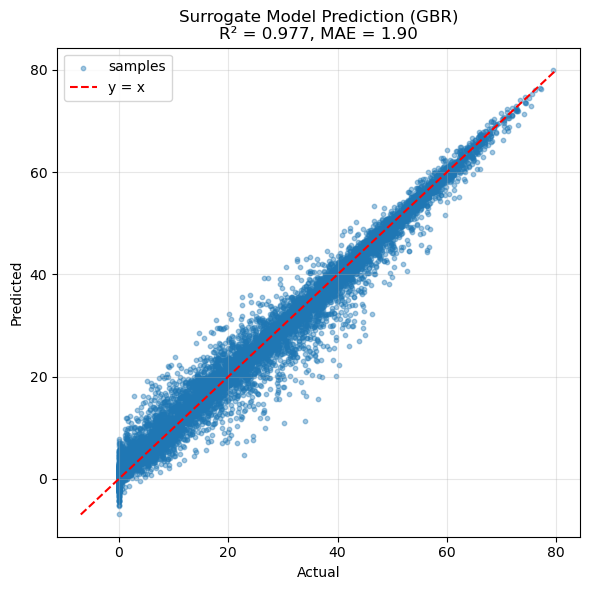

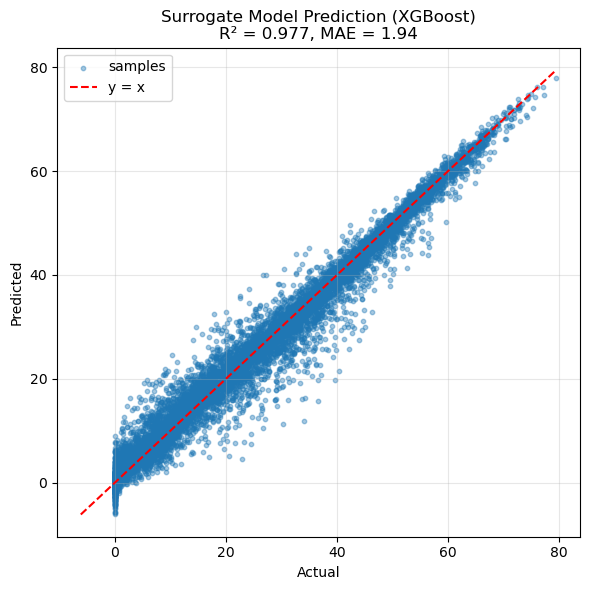

In [56]:
plot_pred_vs_actual(best_gbr, X_test, y_test, title="Surrogate Model Prediction (GBR)")
plot_pred_vs_actual(best_xgb, X_test, y_test, title="Surrogate Model Prediction (XGBoost)")

# predication

In [48]:
# 整年数据
df_model = pd.read_csv("preprocess.csv")

feature_cols = [
    "Tset_outside",
    "Tset_middle",
    "Dry Bulb Temperature",
    "Dry Bulb Temperature_lag1",
    "Dry Bulb Temperature_lag2",
    "Relative Humidity",
    "Relative Humidity_lag1",
    "Relative Humidity_lag2",
    "Diffuse Horizontal Radiation",
    "Diffuse Horizontal Radiation_lag1",
    "Diffuse Horizontal Radiation_lag2"
]

# 前 3 个月（训练时用的）
df_train = df_model[df_model['month'] <= 3].copy()

# 后 8 个月（现在要用来预测的）
df_future = df_model[df_model['month'] > 3].copy()

# 未来 8 个月的输入特征
X_future = df_future[feature_cols].values

# 用训练好的模型做预测
y_future_pred = best_xgb.predict(X_future)

# 把预测结果存回 df_future，方便后续分析/画图/导出
df_future['E_HVAC_pred'] = y_future_pred

from sklearn.metrics import r2_score, mean_absolute_error

y_future_true = df_future['E_HVAC'].values

print("R2 (months 4–12):", r2_score(y_future_true, y_future_pred))
print("MAE (months 4–12):", mean_absolute_error(y_future_true, y_future_pred))

output_path =  "prediction.csv"
df_model.to_csv(output_path, index=False)

print("✅ 已保存整合文件到：", output_path)

R2 (months 4–12): 0.7473084635084692
MAE (months 4–12): 7.517954039525674
✅ 已保存整合文件到： prediction.csv
